# Web Service Classifcation using DL for top 10,20,30,40,50 Web Service Categories

# Web Service Classification using DL (BI- LSTM)

## 1. Load Python Modules

In [1]:
import pandas as pd
import numpy as np
import re
import os
import pickle
import warnings

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout,GlobalMaxPooling1D,LayerNormalization

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Notebook settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

# Setup directories
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)

2025-06-12 12:32:17.622139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749731537.785063   21322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749731537.824176   21322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749731538.167786   21322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749731538.168090   21322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749731538.168094   21322 computation_placer.cc:177] computation placer alr

## 2. Generate Report in CSV

In [2]:
def generate_report_csv(report_dict, confusion_mat, class_labels, output_file="DL-Report.csv"):
    df = pd.DataFrame(report_dict).transpose()

    # Filter only class label rows
    df = df.loc[[str(cls) for cls in class_labels if str(cls) in df.index]].copy()

    # Compute per-class accuracy
    row_sums = confusion_mat.sum(axis=1)
    diagonal = np.diag(confusion_mat)
    per_class_accuracy = (diagonal / row_sums).round(2)

    df['accuracy'] = per_class_accuracy
    if 'support' in df.columns:
        df = df.drop(columns=['support'])

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Category'}, inplace=True)

    df.to_csv(f"results/{output_file}", index=False)
    print(f"Classification report saved to: {output_file}")

## 3. Confusion Matrix - Show - Save

In [3]:
def generate_confusion_heatmap(cm, class_names, name):
    n_classes = len(class_names)
    figsize = (18, 18) if n_classes >= 40 else (8, 8)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 6})
    plt.title(f'Confusion Matrix: {name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    save_path = f"charts/DL_confusion_matrix_{name.replace(' ', '_')}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

## 4. Evaluate Model

In [4]:
def evaluate_and_report(y_test, y_pred, name, labels, class_names):
    print(f"\n {name} Classification Report:\n")
    print(classification_report(y_test, y_pred,target_names=class_names))

    report = classification_report(y_test, y_pred, output_dict=True, labels=labels)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    generate_report_csv(report, cm, class_labels=labels, output_file=f"DL-Report-{name}.csv")
    generate_confusion_heatmap(cm, class_names, name)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

## 5. Build - Model

In [5]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)


def build_dl_model(input_length, num_classes, model_type="rnn"):
    model = Sequential()
    # Embedding Layer 
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=input_length))
    # 1st BiLSTM with reduced units
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    # Replacing 2nd BiLSTM with GlobalMaxPooling 
    model.add(LayerNormalization())
    model.add(GlobalMaxPooling1D())
    # Dense Layers (smaller size and stronger dropout)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 6. Train the Model 

In [6]:

def train_dl_model(df, model_type, name, max_len=150):
    df = df.dropna(subset=["Service Description", "Service Classification"])
    df["Service Description"] = df["Service Description"].apply(clean_text)

    texts = df['Service Description'].values
    labels = df['Service Classification'].values

    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(texts)
    X_seq = tokenizer.texts_to_sequences(texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    le = LabelEncoder()
    y_enc = le.fit_transform(labels)
    y_cat = to_categorical(y_enc)
    num_classes = y_cat.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_enc), y=y_enc)
    class_weights = dict(enumerate(class_weights))

    model = build_dl_model(input_length=max_len, num_classes=num_classes, model_type=model_type)

    # Train and capture history
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1
    )

    # Plotting training history
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)  # Fix: convert from one-hot to labels

    labels = le.inverse_transform(np.arange(num_classes))  # class names (strings)

    # Fix: use y_true (not y_test anymore)
    result = evaluate_and_report(y_true, y_pred, name, np.arange(num_classes), labels)
    result["model"] = "BI-LSTM"
    return result


## 6. Models


Processing Top 10 Web Service Categories
Epoch 1/30


I0000 00:00:1749731552.951584   21322 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1749731558.239387   21891 cuda_dnn.cc:529] Loaded cuDNN version 90701


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1687 - loss: 2.3321 - val_accuracy: 0.5445 - val_loss: 1.6718
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5023 - loss: 1.4448 - val_accuracy: 0.7264 - val_loss: 1.0092
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7253 - loss: 0.8170 - val_accuracy: 0.7450 - val_loss: 0.8872
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8400 - loss: 0.5079 - val_accuracy: 0.7477 - val_loss: 0.8257
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9148 - loss: 0.2642 - val_accuracy: 0.7543 - val_loss: 0.9014
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9569 - loss: 0.1677 - val_accuracy: 0.7689 - val_loss: 0.9198
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9743 - loss: 0.1048 - val_accuracy: 0.7703 - val_loss: 1.0260
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9799 - loss: 0.0786 - val_accuracy: 0.7410 - val_loss: 1.

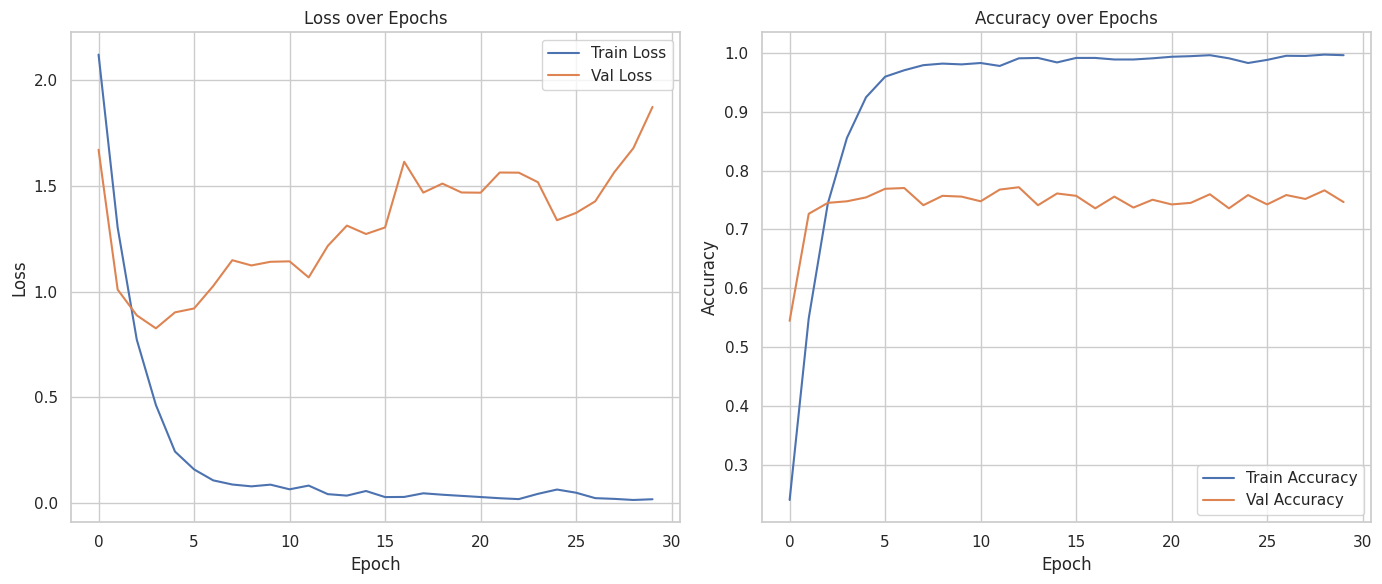

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

 BI-LSTM Top 10 Classification Report:

              precision    recall  f1-score   support

  Enterprise       0.73      0.57      0.64        82
   Financial       0.80      0.81      0.81       138
  Government       0.77      0.70      0.74        61
     Mapping       0.76      0.94      0.84        72
   Messaging       0.77      0.86      0.81       102
    Payments       0.57      0.86      0.68        92
      Social       0.69      0.69      0.69        87
   Telephony       0.67      0.62      0.64        60
       Tools       0.83      0.62      0.71       154
   eCommerce       0.84      0.72      0.77        93

    accuracy                           0.74       941
   macro avg       0.74      0.74      0.73       941
weighted avg       0.75      0.74      0.74       941

Classification report saved to: DL-Report-BI-LSTM Top 10.csv


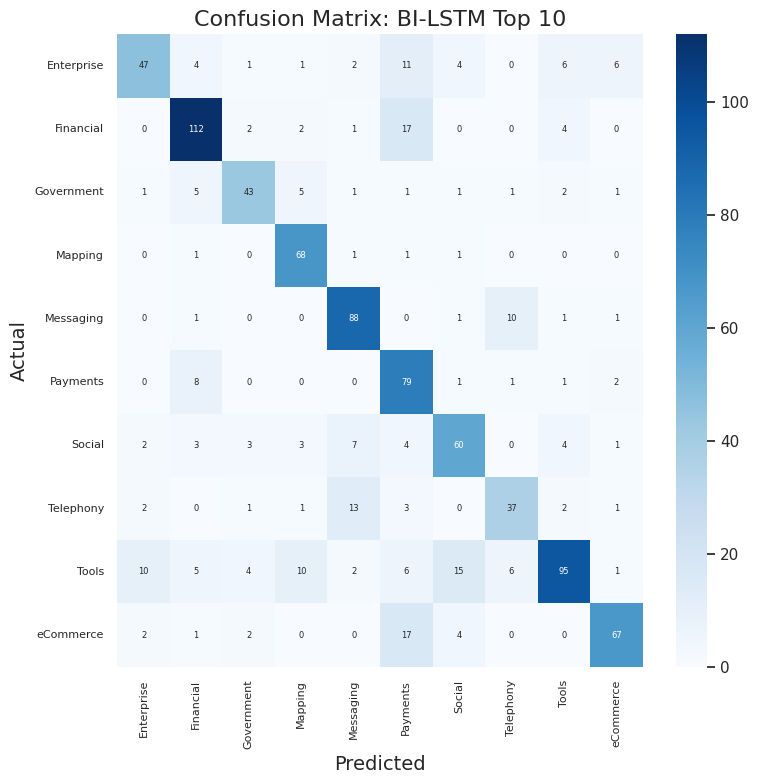

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_10.png
{'accuracy': 0.7396386822529224, 'precision': 0.7520366706477004, 'recall': 0.7396386822529224, 'f1_score': 0.7378766693875032, 'model': 'BI-LSTM'}

Processing Top 20 Web Service Categories
Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1010 - loss: 3.0169 - val_accuracy: 0.4852 - val_loss: 2.1538
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4038 - loss: 1.9152 - val_accuracy: 0.6272 - val_loss: 1.4668
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6346 - loss: 1.1353 - val_accuracy: 0.6751 - val_loss: 1.2024
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7575 - loss: 0.7564 - val_accuracy: 0.6925 - val_loss: 1.0833
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8275 - loss: 0.5493 - val_accuracy: 0.6760 - val_loss: 1.1263
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8661 - loss: 0.3960 - val

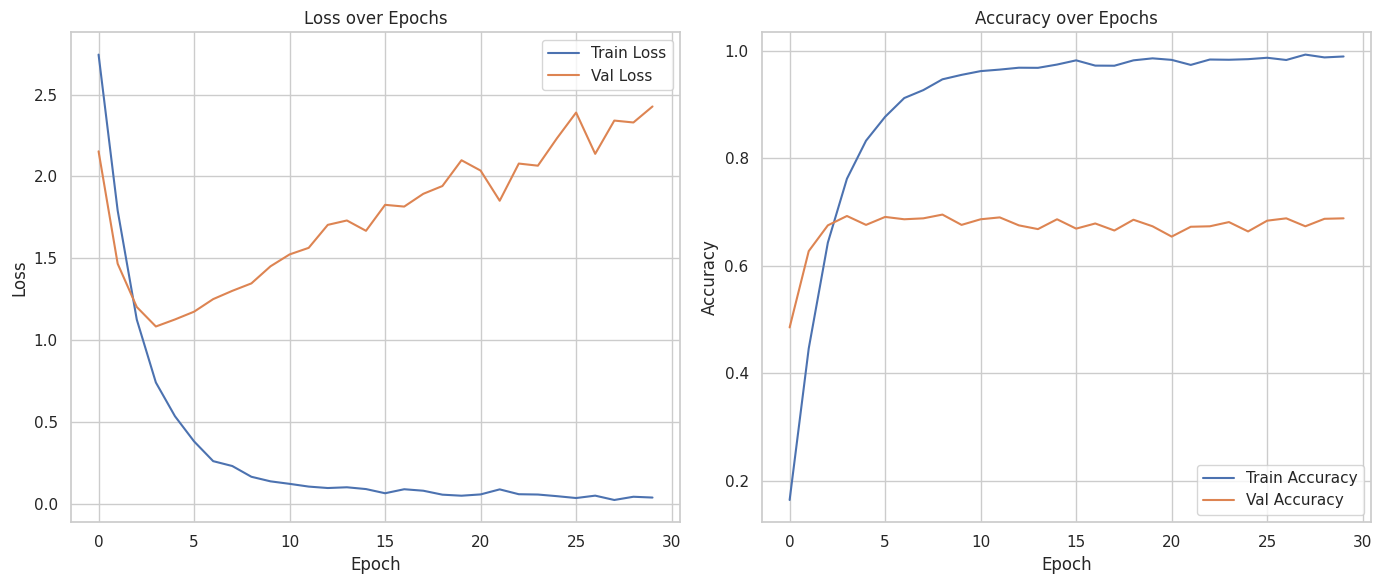

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

 BI-LSTM Top 20 Classification Report:

                precision    recall  f1-score   support

   Advertising       0.66      0.69      0.67        45
         Email       0.92      0.69      0.79        51
    Enterprise       0.45      0.59      0.51        82
     Financial       0.81      0.77      0.79       137
    Government       0.65      0.66      0.65        61
       Mapping       0.69      0.68      0.69        72
     Messaging       0.77      0.77      0.77       102
      Payments       0.68      0.88      0.76        92
     Reference       0.39      0.18      0.25        50
       Science       0.74      0.88      0.80        60
        Search       0.48      0.70      0.57        50
      Security       0.51      0.62      0.56        50
        Social       0.74      0.49      0.59        87
        Sports       0.91      0.89      0.90        46
     Telephony       0.70      0.53      0.60        60
         Tools       0.

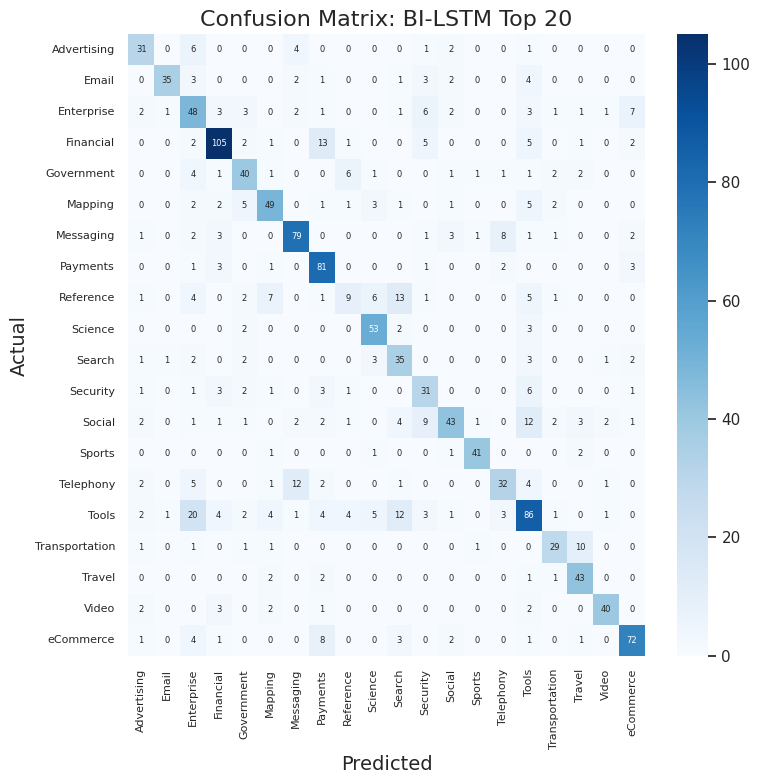

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_20.png
{'accuracy': 0.6843205574912892, 'precision': 0.6916695975932666, 'recall': 0.6843205574912892, 'f1_score': 0.6808340884912616, 'model': 'BI-LSTM'}

Processing Top 30 Web Service Categories
Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.0562 - loss: 3.3281 - val_accuracy: 0.2821 - val_loss: 2.8884
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2459 - loss: 2.6811 - val_accuracy: 0.5628 - val_loss: 1.9684
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4945 - loss: 1.7005 - val_accuracy: 0.6164 - val_loss: 1.5479
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6256 - loss: 1.1822 - val_accuracy: 0.6396 - val_loss: 1.3968
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7208 - loss: 0.8750 - val_accuracy: 0.6474 - val_loss: 1.3801
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7878 - loss: 0.6147 - val

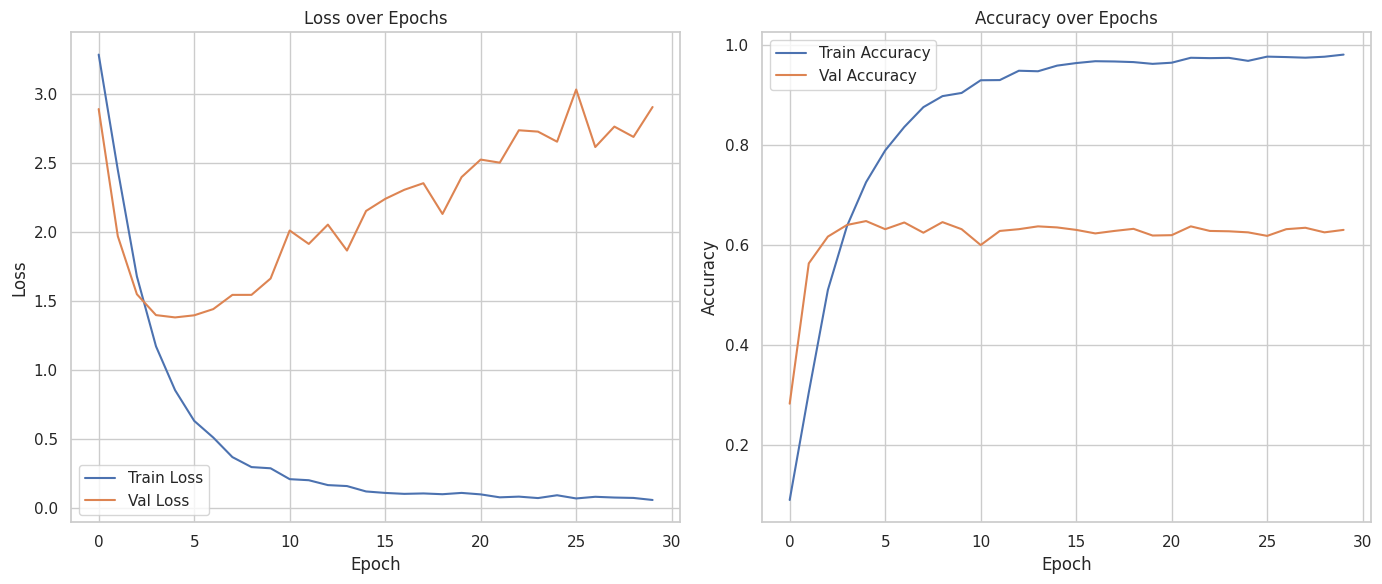

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

 BI-LSTM Top 30 Classification Report:

                    precision    recall  f1-score   support

       Advertising       0.67      0.69      0.68        45
           Bitcoin       0.62      0.79      0.70        29
             Cloud       0.62      0.60      0.61        35
              Data       0.33      0.36      0.34        28
          Database       0.33      0.22      0.27        27
         Education       0.70      0.74      0.72        43
             Email       0.76      0.73      0.74        51
        Enterprise       0.60      0.34      0.43        82
         Financial       0.78      0.72      0.75       137
             Games       0.85      0.68      0.76        41
        Government       0.74      0.52      0.62        61
           Mapping       0.67      0.72      0.69        72
         Messaging       0.82      0.83      0.83       102
             Music       0.87      0.89      0.88        38
             Other 

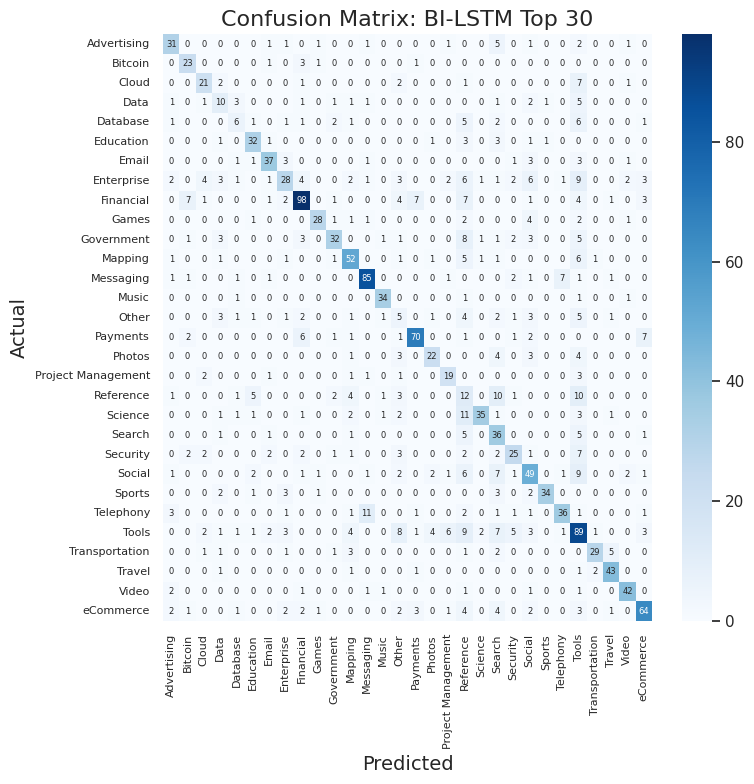

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_30.png
{'accuracy': 0.6360045146726863, 'precision': 0.6706222897134395, 'recall': 0.6360045146726863, 'f1_score': 0.6451994900159094, 'model': 'BI-LSTM'}

Processing Top 40 Web Service Categories
Epoch 1/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0248 - loss: 3.7455 - val_accuracy: 0.1315 - val_loss: 3.3899
Epoch 2/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1520 - loss: 3.1260 - val_accuracy: 0.5118 - val_loss: 2.3230
Epoch 3/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3620 - loss: 2.1845 - val_accuracy: 0.5806 - val_loss: 1.7810
Epoch 4/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5234 - loss: 1.5488 - val_accuracy: 0.6005 - val_loss: 1.6064
Epoch 5/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6304 - loss: 1.1210 - val_accuracy: 0.6129 - val_loss: 1.5301
Epoch 6/30
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7184 - loss: 0.8269 - val

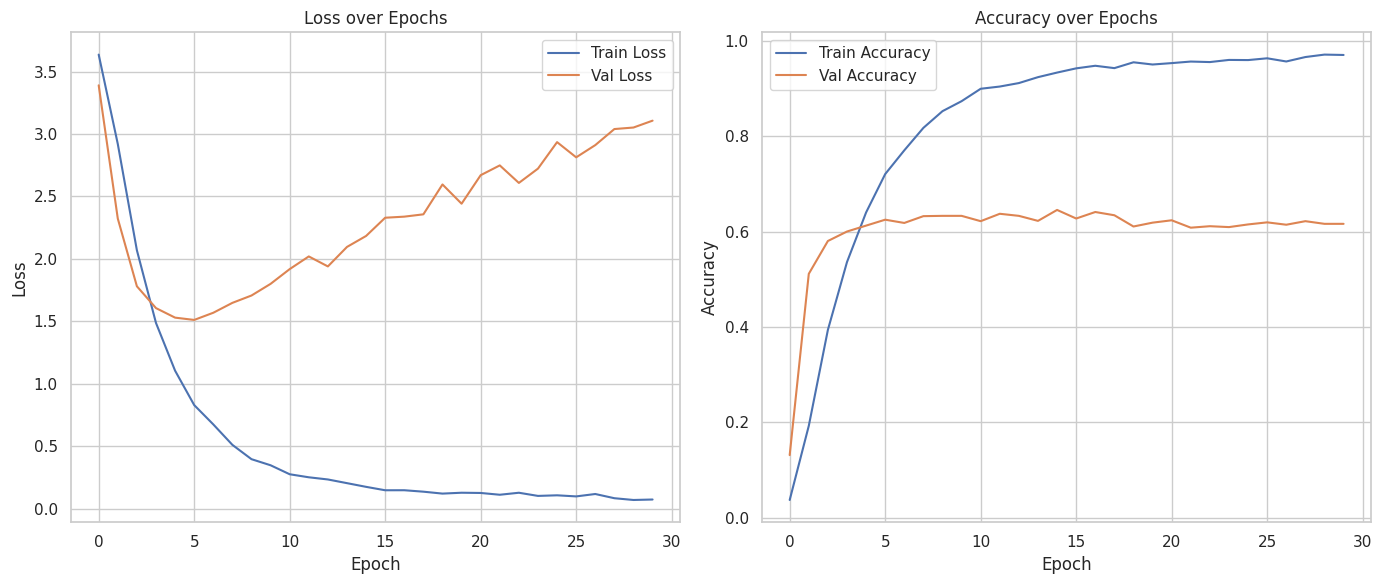

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 BI-LSTM Top 40 Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.66      0.64      0.65        45
              Analytics       0.33      0.17      0.23        23
Application Development       0.15      0.24      0.19        25
                Backend       0.53      0.37      0.43        27
                Banking       0.64      0.73      0.68        22
                Bitcoin       0.63      0.59      0.61        29
                  Cloud       0.44      0.43      0.43        35
                   Data       0.33      0.32      0.33        28
               Database       0.21      0.26      0.23        27
              Education       0.68      0.58      0.63        43
                  Email       0.64      0.76      0.70        51
             Enterprise       0.36      0.33      0.34        82
                 Events       0.71      0.77      0.74        22
         

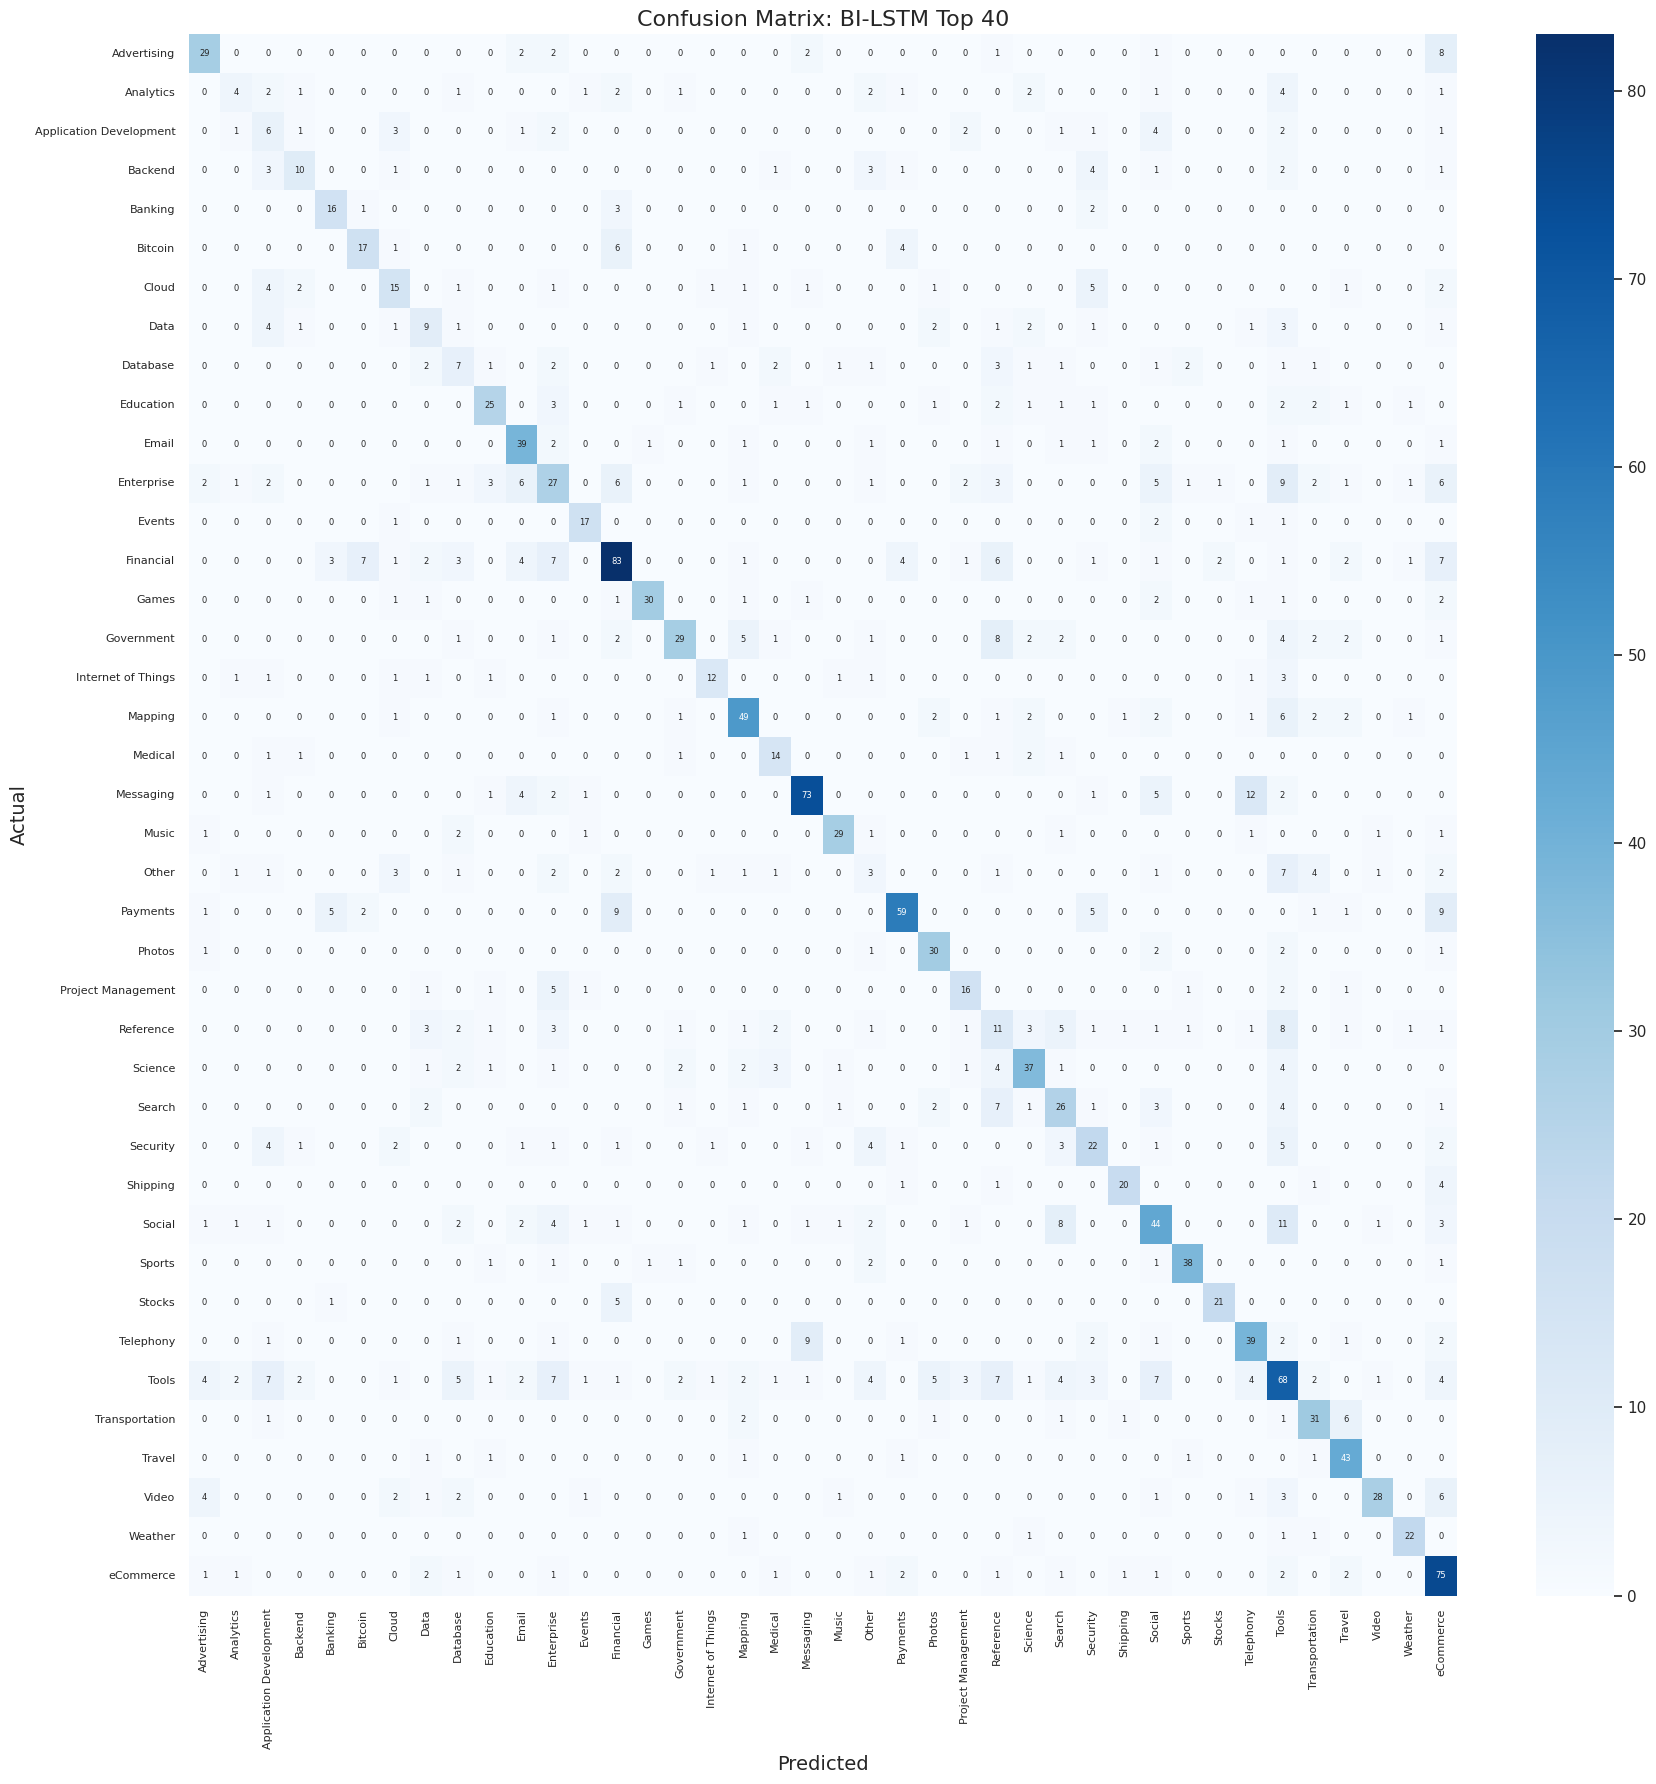

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_40.png
{'accuracy': 0.5821339950372209, 'precision': 0.5979177588999084, 'recall': 0.5821339950372209, 'f1_score': 0.5841876398432554, 'model': 'BI-LSTM'}

Processing Top 50 Web Service Categories
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.0300 - loss: 3.9461 - val_accuracy: 0.1141 - val_loss: 3.6704
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1315 - loss: 3.4141 - val_accuracy: 0.4575 - val_loss: 2.5501
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3539 - loss: 2.3693 - val_accuracy: 0.5157 - val_loss: 2.1318
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4948 - loss: 1.7050 - val_accuracy: 0.5305 - val_loss: 1.9020
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6056 - loss: 1.2703 - val_accuracy: 0.5436 - val_loss: 1.8170
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6631 - loss: 0.9888 - val

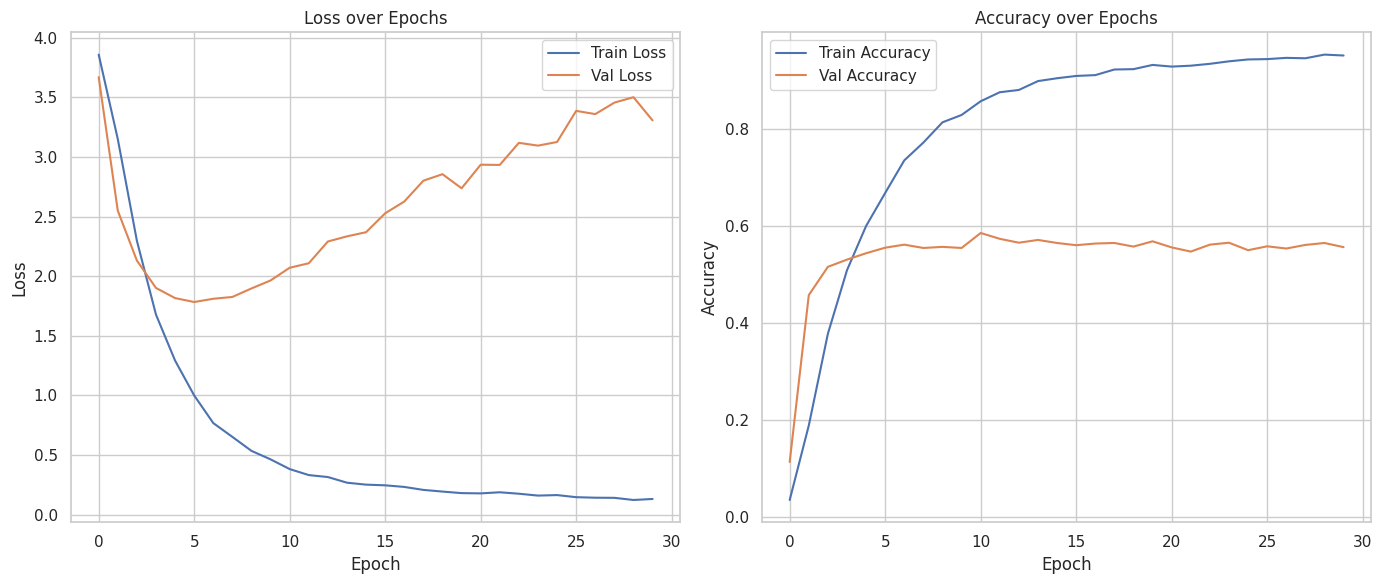

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

 BI-LSTM Top 50 Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.66      0.64      0.65        45
              Analytics       0.36      0.35      0.36        23
Application Development       0.37      0.28      0.32        25
                Backend       0.50      0.19      0.27        27
                Banking       0.67      0.73      0.70        22
                Bitcoin       0.74      0.86      0.79        29
                   Chat       0.50      0.56      0.53        16
                  Cloud       0.67      0.40      0.50        35
                   Data       0.45      0.36      0.40        28
               Database       0.19      0.33      0.24        27
                Domains       0.65      0.88      0.75        17
              Education       0.69      0.79      0.74        43
                  Email       0.60      0.86      0.71        51
         

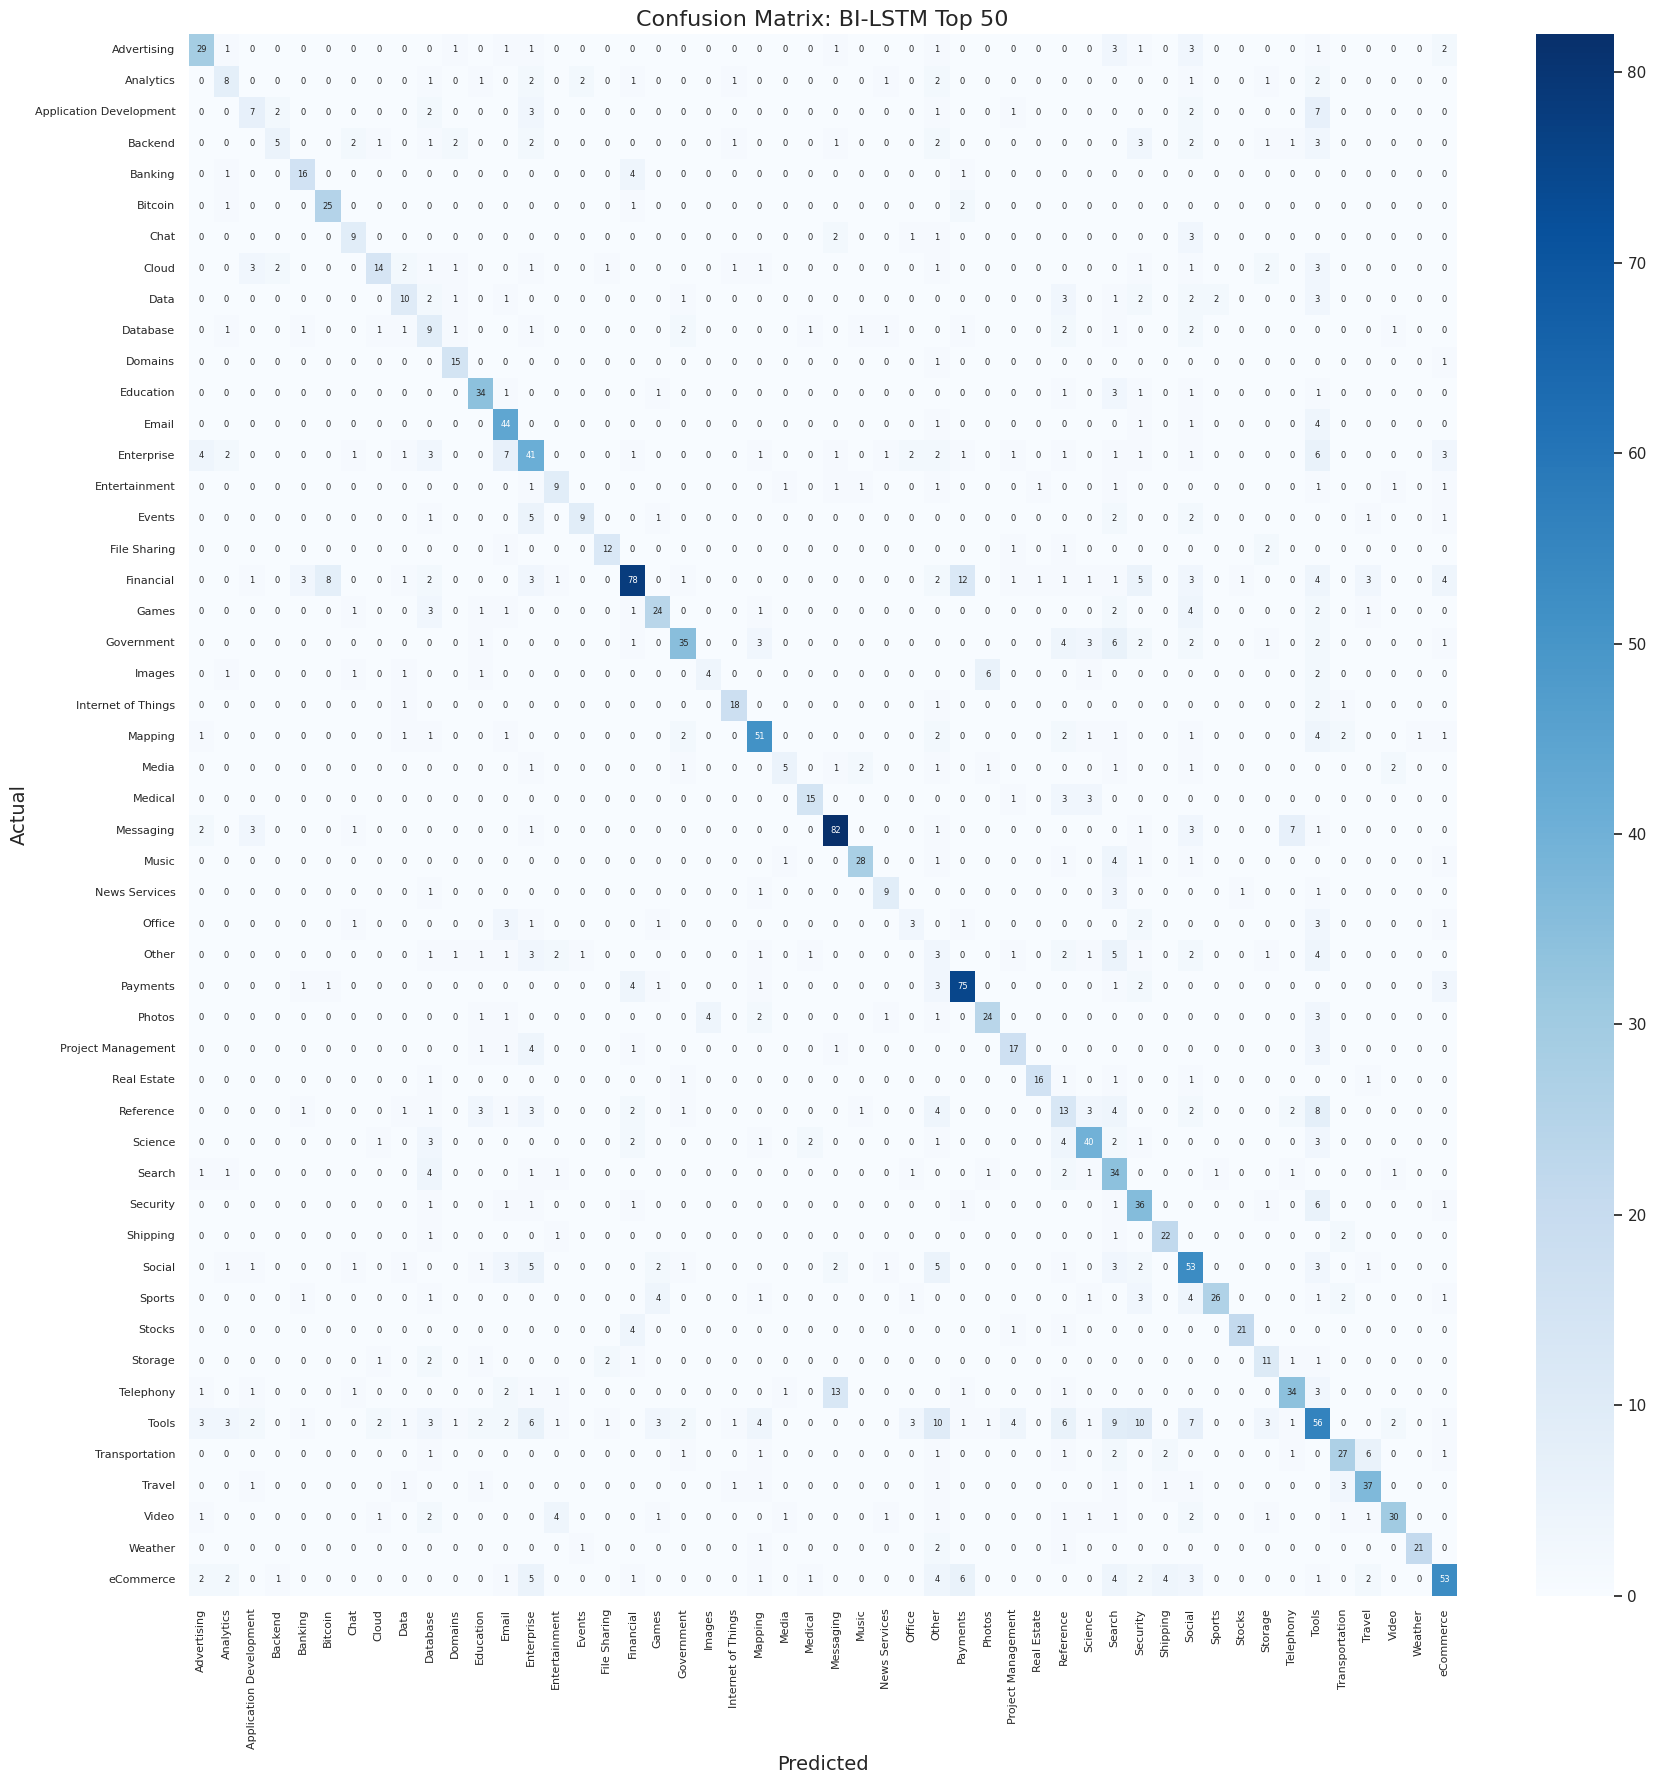

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_50.png
{'accuracy': 0.5916970802919708, 'precision': 0.6184488909377183, 'recall': 0.5916970802919708, 'f1_score': 0.5956400417658837, 'model': 'BI-LSTM'}


In [7]:
if __name__ == "__main__":
    dl_final_results = {}

    for n in [10,20,30,40,50]:
        print(f"\nProcessing Top {n} Web Service Categories")
        df = pd.read_csv(f"../data-preprocessing/Pre_Processed_Top_{n}_Web_Services_Categories.csv")

        results = []
        for model_type in ["BI-LSTM"]:
            name = f"{model_type.upper()} Top {n}"
            result = train_dl_model(df, model_type, name)
            results.append(result)
            print(result)
        dl_final_results[n] = results

    # Save all results
    with open("results/dl_final_results.pkl", "wb") as f:
        pickle.dump(dl_final_results, f)

## 5. Performance and Plots

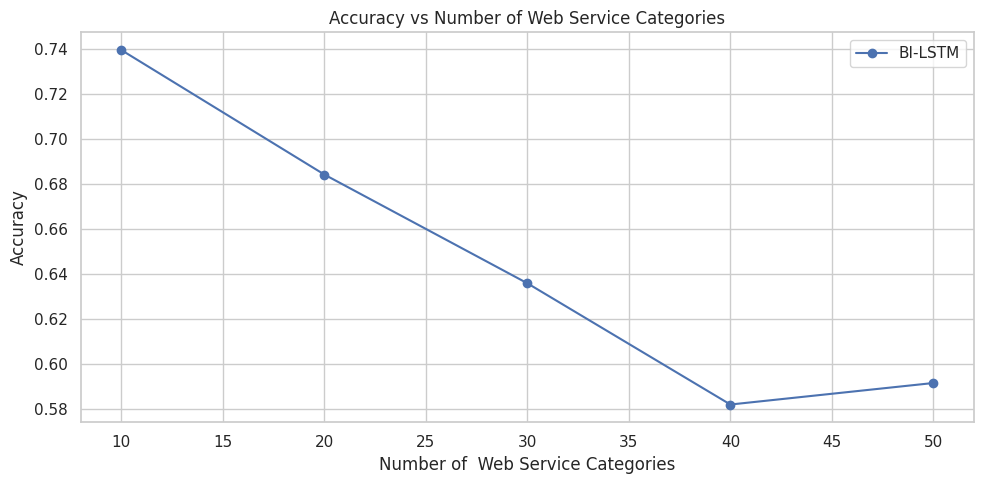

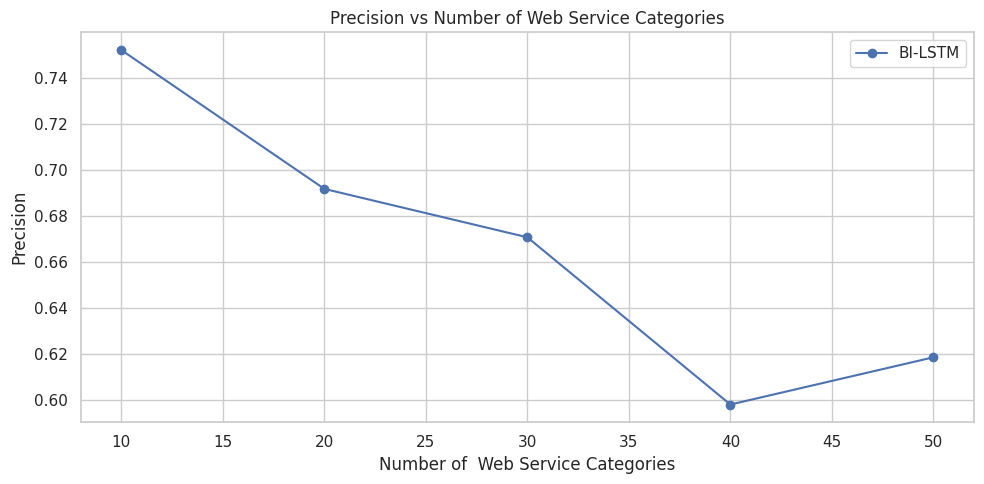

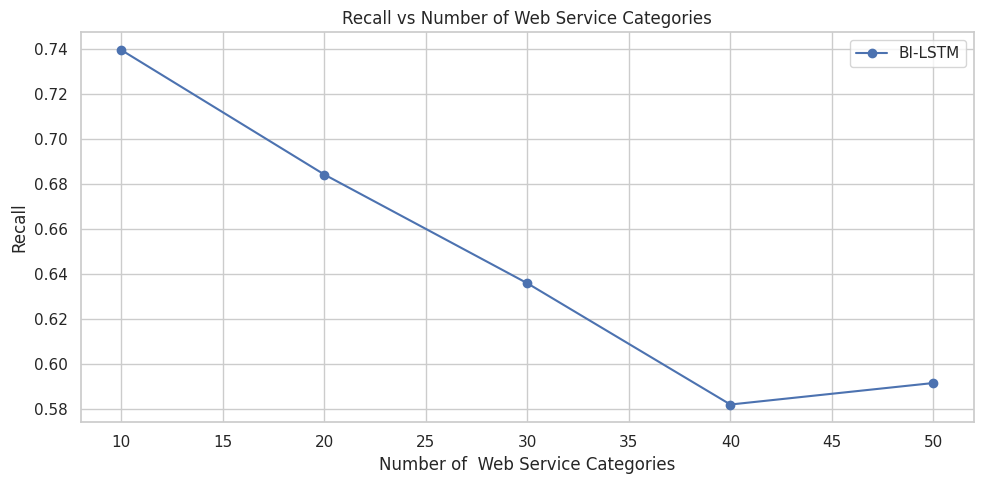

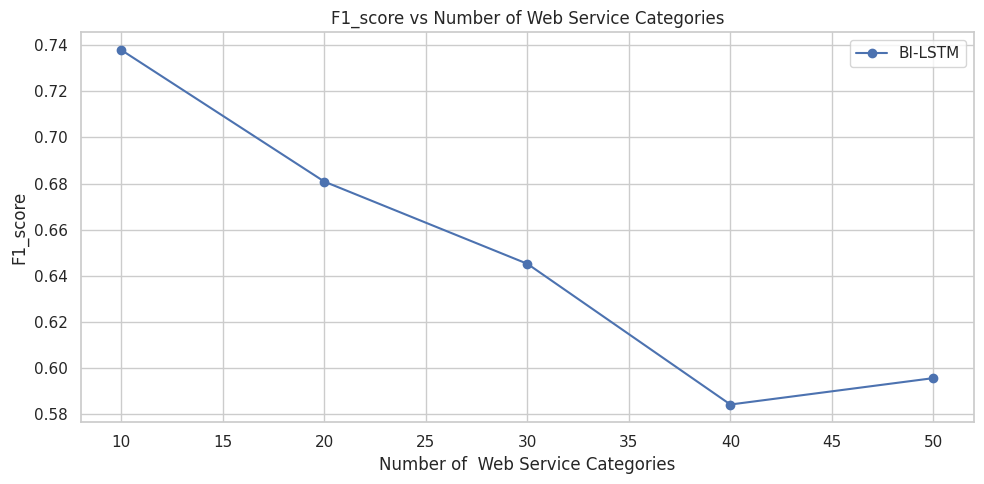

In [8]:
model_metrics = {}

for n, results in dl_final_results.items():
    for entry in results:
        model = entry['model'].split('Top')[0].strip()  
        if model not in model_metrics:
            model_metrics[model] = {'n': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
        
        model_metrics[model]['n'].append(n)
        model_metrics[model]['accuracy'].append(entry['accuracy'])
        model_metrics[model]['precision'].append(entry['precision'])
        model_metrics[model]['recall'].append(entry['recall'])
        model_metrics[model]['f1_score'].append(entry['f1_score'])

def plot_metric(metric_name):
    plt.figure(figsize=(10, 5))
    for model, data in model_metrics.items():
        plt.plot(data['n'], data[metric_name], marker='o', label=model)
    plt.title(f'{metric_name.capitalize()} vs Number of Web Service Categories')
    plt.xlabel('Number of  Web Service Categories')
    plt.ylabel(metric_name.capitalize())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plot_path = f"charts/DL_Model_Performance__{metric_name}.png"
    plt.savefig(plot_path)
    plt.show()

plot_metric('accuracy')
plot_metric('precision')
plot_metric('recall')
plot_metric('f1_score')

